In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as imgen
from keras.models import load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

In [2]:
data = pd.read_csv("age_gender.csv")
data.head(5)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [3]:
data.shape

(23705, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [5]:
data.describe(include='all')

,age,ethnicity,gender,img_name,pixels
count,23705.000000,23705.000000,23705.000000,23705,23705
unique,NaN,NaN,NaN,23479,23315
top,NaN,NaN,NaN,20170110173815028.jpg.chip.jpg,10 21 33 31 42 54 66 75 73 73 80 87 91 96 102 ...
freq,NaN,NaN,NaN,7,4
mean,33.300907,1.269226,0.477283,NaN,NaN
std,19.885708,1.345638,0.499494,NaN,NaN
min,1.000000,0.000000,0.000000,NaN,NaN
25%,23.000000,0.000000,0.000000,NaN,NaN
50%,29.000000,1.000000,0.000000,NaN,NaN
75%,45.000000,2.000000,1.000000,NaN,NaN


# Data Preprocessing

In [6]:
# Getting Image Data
def toPixels(pixels):
    arr = np.array(pixels.split(), 'float64')
    arr = arr.reshape(48, 48)
    return arr

In [7]:
%%time
data['pixels'] = data['pixels'].apply(toPixels)

pixels = np.reshape(data['pixels'].to_list(), (data.shape[0], 48, 48, 1))

pixels.shape

CPU times: total: 9.39 s
Wall time: 10.3 s


(23705, 48, 48, 1)

# Age Prediction Model

## Generating Datasets for Age Prediction

In [8]:
# Split the data into training data and testing data
X_train, X_test, Y_train, Y_test = train_test_split(pixels, np.array(data['age']), random_state = 42, test_size = 0.2)

# Split the training set to be training data and validation data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state = 21, test_size = 0.15)

In [9]:
print(X_train.shape, Y_train.shape, X_test.shape, X_val.shape)

(16119, 48, 48, 1) (16119,) (4741, 48, 48, 1) (2845, 48, 48, 1)


## Image data Generator

In [10]:
# Training Data Generation
traingen = imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
                )

In [11]:
# Validation Data Generation
valgen = imgen(rescale=1./255,
               zoom_range=0.2,
               shear_range=0.2,
               horizontal_flip=True
              )

In [12]:
# Testing Data Generation
testgen = imgen(rescale=1./255)

In [13]:
# Training Data
age_train_ds = traingen.flow(X_train, Y_train, batch_size = 32)

# Validation Data
age_val_ds = valgen.flow(X_val, Y_val, batch_size = 32)

# Testing Data
age_test_ds = testgen.flow(X_test, Y_test, batch_size = 32, shuffle=False)

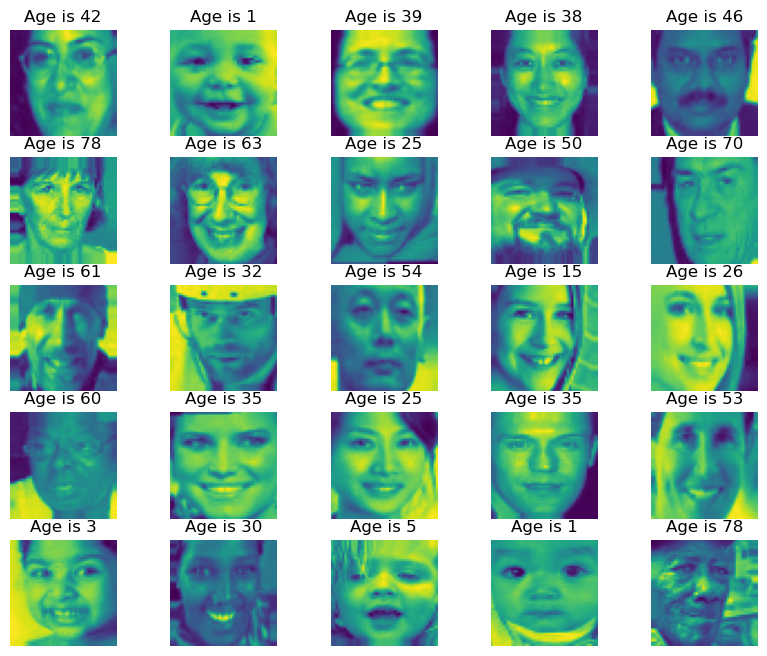

In [14]:
# Visualizing one batch

def showImagesAge(img, label):
    plt.figure(figsize=(10,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title('Age is {}'.format(label[i]))
        plt.axis('off')
    plt.show()

X, Y = next(age_train_ds)
showImagesAge(X,Y)

## Model

In [15]:
image_input = keras.Input(shape=(48, 48, 1))

# layer 1: relu
l1 = Conv2D(32, (3,3), activation='relu')(image_input)

# layer 2: relu
l2 = Conv2D(32, (3,3), activation='relu')(l1)

# layer 3
l3 = MaxPooling2D(pool_size=(2, 2))(l2)

# layer 4
l4 = Dropout(0.30)(l3)

# layer 5: relu
l5 = Conv2D(64, (3,3), activation='relu')(l4)

# layer 6: relu
l6 = Conv2D(128, (3,3), activation='relu')(l5)

# layer 7
#l7 = BatchNormalization()(l6)

l8 = Flatten()(l6)

l9 = Dense(256, activation='relu')(l8)

image_output = Dense(1)(l9)

model_age = keras.Model(image_input, image_output)

model_age.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496     
                                                             

In [16]:
# Compiling the model
model_age.compile(optimizer='adam', loss='mse', 
                  metrics=[keras.metrics.mean_absolute_error])

## Defining callbacks

In [17]:
# MAE 

my_calls = [keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3), 
            keras.callbacks.ModelCheckpoint("Model_age.h5", verbose=1, save_best_only=True)]

## Training the model for age

In [18]:
hist_age = model_age.fit(age_train_ds, epochs=35, validation_data=age_val_ds, callbacks=my_calls)

Epoch 1/35
504/504 [==============================] - ETA: 0s - loss: 349.9644 - mean_absolute_error: 14.2928
Epoch 1: val_loss improved from inf to 246.08667, saving model to Model_age.h5


C:\Users\Alive\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 52s 101ms/step - loss: 349.9644 - mean_absolute_error: 14.2928 - val_loss: 246.0867 - val_mean_absolute_error: 12.4523
Epoch 2/35
504/504 [==============================] - ETA: 0s - loss: 225.8899 - mean_absolute_error: 11.3912
Epoch 2: val_loss improved from 246.08667 to 160.87956, saving model to Model_age.h5
504/504 [==============================] - 61s 120ms/step - loss: 225.8899 - mean_absolute_error: 11.3912 - val_loss: 160.8796 - val_mean_absolute_error: 9.3653
Epoch 3/35
504/504 [==============================] - ETA: 0s - loss: 175.9432 - mean_absolute_error: 9.8623
Epoch 3: val_loss improved from 160.87956 to 141.25908, saving model to Model_age.h5
504/504 [==============================] - 63s 125ms/step - loss: 175.9432 - mean_absolute_error: 9.8623 - val_loss: 141.2591 - val_mean_absolute_error: 8.5542
Epoch 4/35
504/504 [==============================] - ETA: 0s - loss: 148.8832 - mean_absolute_error: 8.9992
Epoch 4: val_loss i

## Test for age prediction

In [19]:
model_age.evaluate(age_test_ds, verbose=1)

149/149 [==============================] - 4s 27ms/step - loss: 102.2834 - mean_absolute_error: 7.3058


[102.28340911865234, 7.305812358856201]

## Loss and MAE

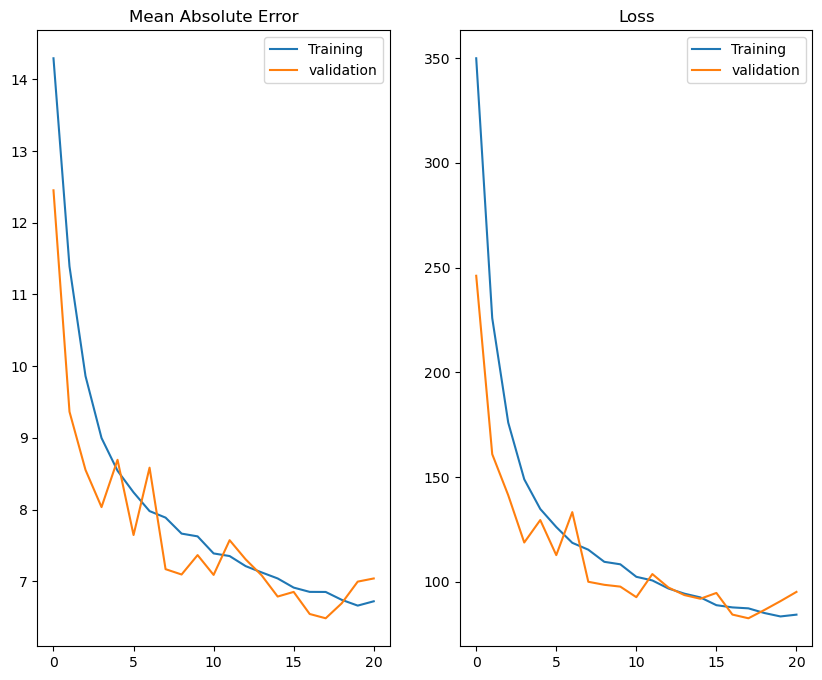

In [42]:
plt.figure(figsize=(10,8))

# First column [MAE]
plt.subplot(1, 2, 1)
plt.plot(hist_age.epoch, hist_age.history['mean_absolute_error'], label='Training')
plt.plot(hist_age.epoch, hist_age.history['val_mean_absolute_error'], label='validation')
plt.title('Mean Absolute Error')
plt.legend()

# Second column [loss]
plt.subplot(1, 2, 2)
plt.plot(hist_age.epoch, hist_age.history['loss'], label='Training')
plt.plot(hist_age.epoch, hist_age.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.show()

## Verifying the Predictions

In [21]:
# Predicting the testing data of age
pred_Age = model_age.predict(age_test_ds, verbose=1)

149/149 [==============================] - 4s 28ms/step


## Plotting predicted vs actual ages

In [25]:
pred_Age[0]

array([27.150063], dtype=float32)

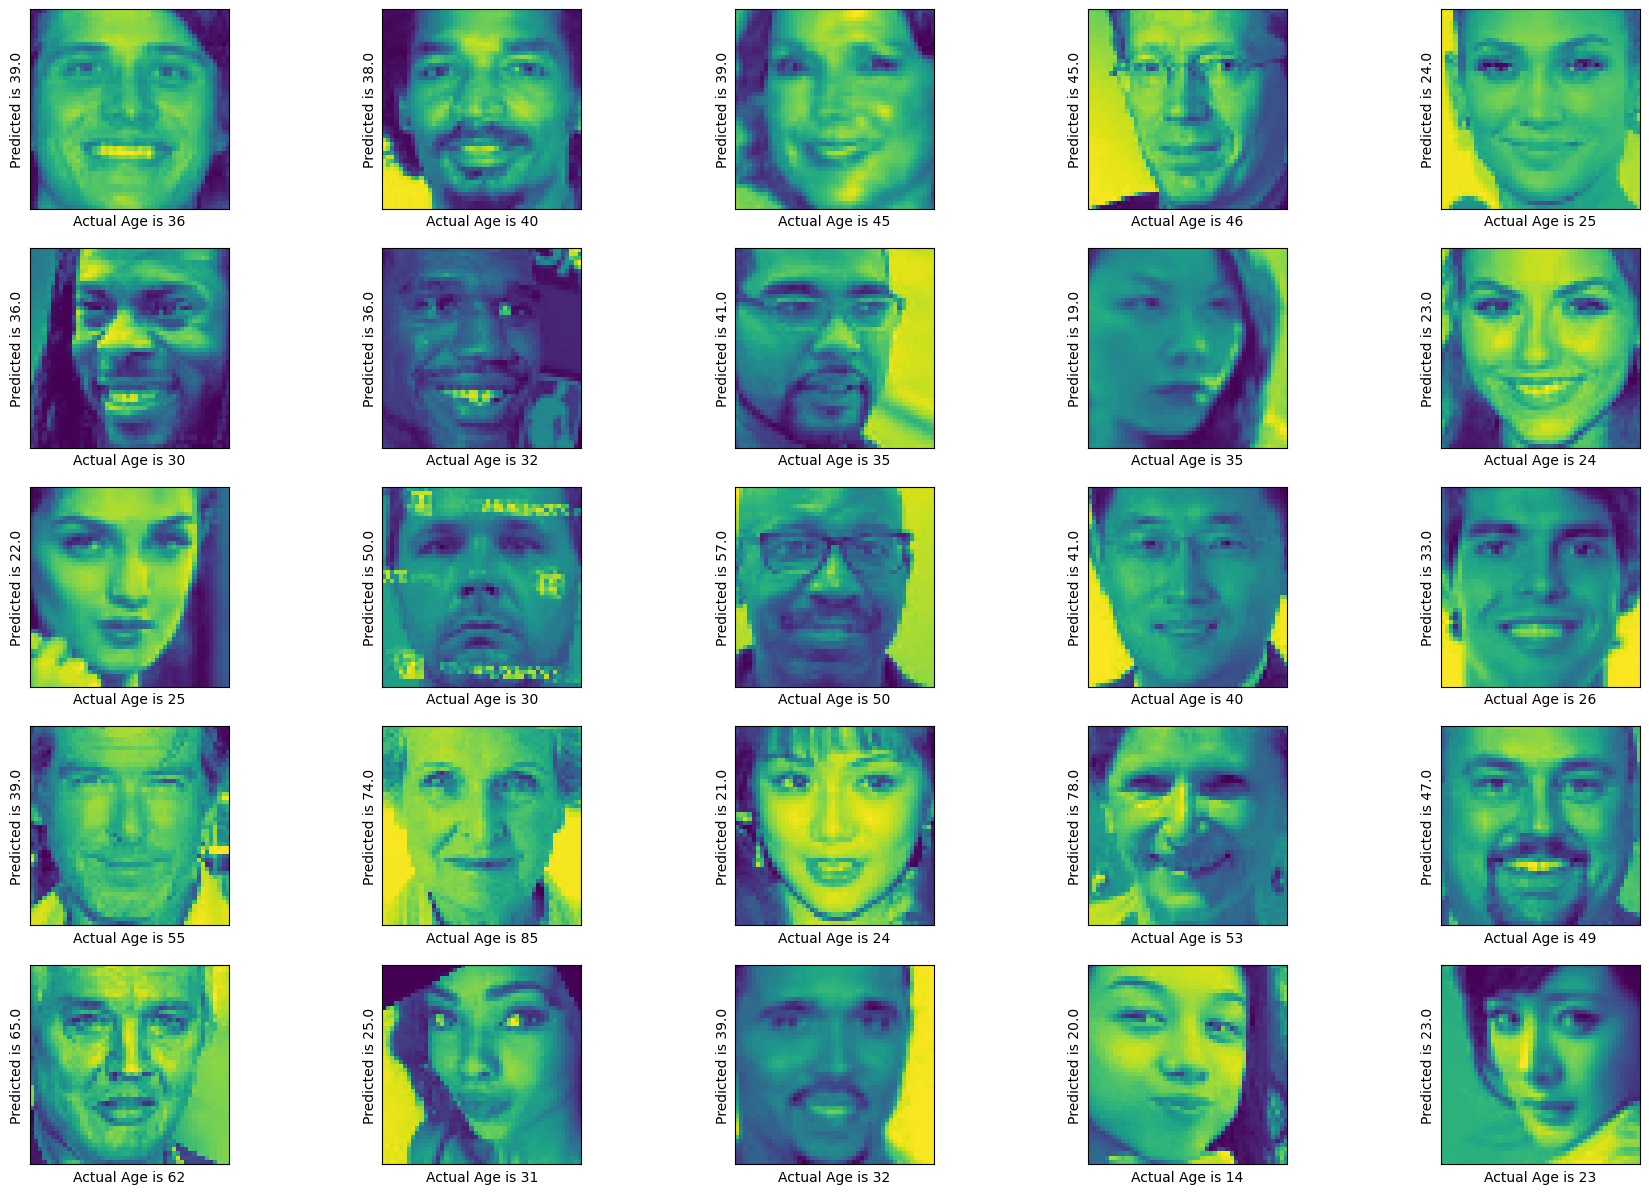

In [29]:
# In integer
pred_age_list = []

for i in pred_Age: pred_age_list.append(np.round(i[0]))
    
def plotAgePA(image, pred, actual):
    plt.figure(figsize=(22,15))
    for i in range(500, 525):
        plt.subplot(5, 5, (i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X_test[i])
        plt.xlabel("Actual Age is {}".format(actual[i]))
        plt.ylabel("Predicted is {}".format(pred[i]))
    plt.show()
    
plotAgePA(X_test, pred_age_list, Y_test)

# Gender Prediction Model

## Dataset for Gender Prediction

In [30]:
# Split the data into training data and testing data
X_train_gender, X_test_gender, Y_train_gender, Y_test_gender = train_test_split(pixels, np.array(data['gender']), random_state = 42, test_size = 0.2)

# Split the training set to be training data and validation data
X_train_gender, X_val_gender, Y_train_gender, Y_val_gender = train_test_split(X_train_gender, Y_train_gender, random_state = 21, test_size = 0.15)

In [31]:
print(X_train_gender.shape, Y_train_gender.shape, X_val_gender.shape, Y_val_gender.shape)

(16119, 48, 48, 1) (16119,) (2845, 48, 48, 1) (2845,)


## Data Generator

In [32]:
gender = ["Male", "Female"]

# Training
gen_train_ds = traingen.flow(X_train_gender, Y_train_gender,
                             batch_size=32
                            )

# Validation
gen_val_ds = valgen.flow(X_val_gender, Y_val_gender,
                         batch_size=32
                        )

# Testing
gen_test_ds = testgen.flow(X_test_gender, Y_test_gender,
                           batch_size=32,
                           shuffle=False
                          )

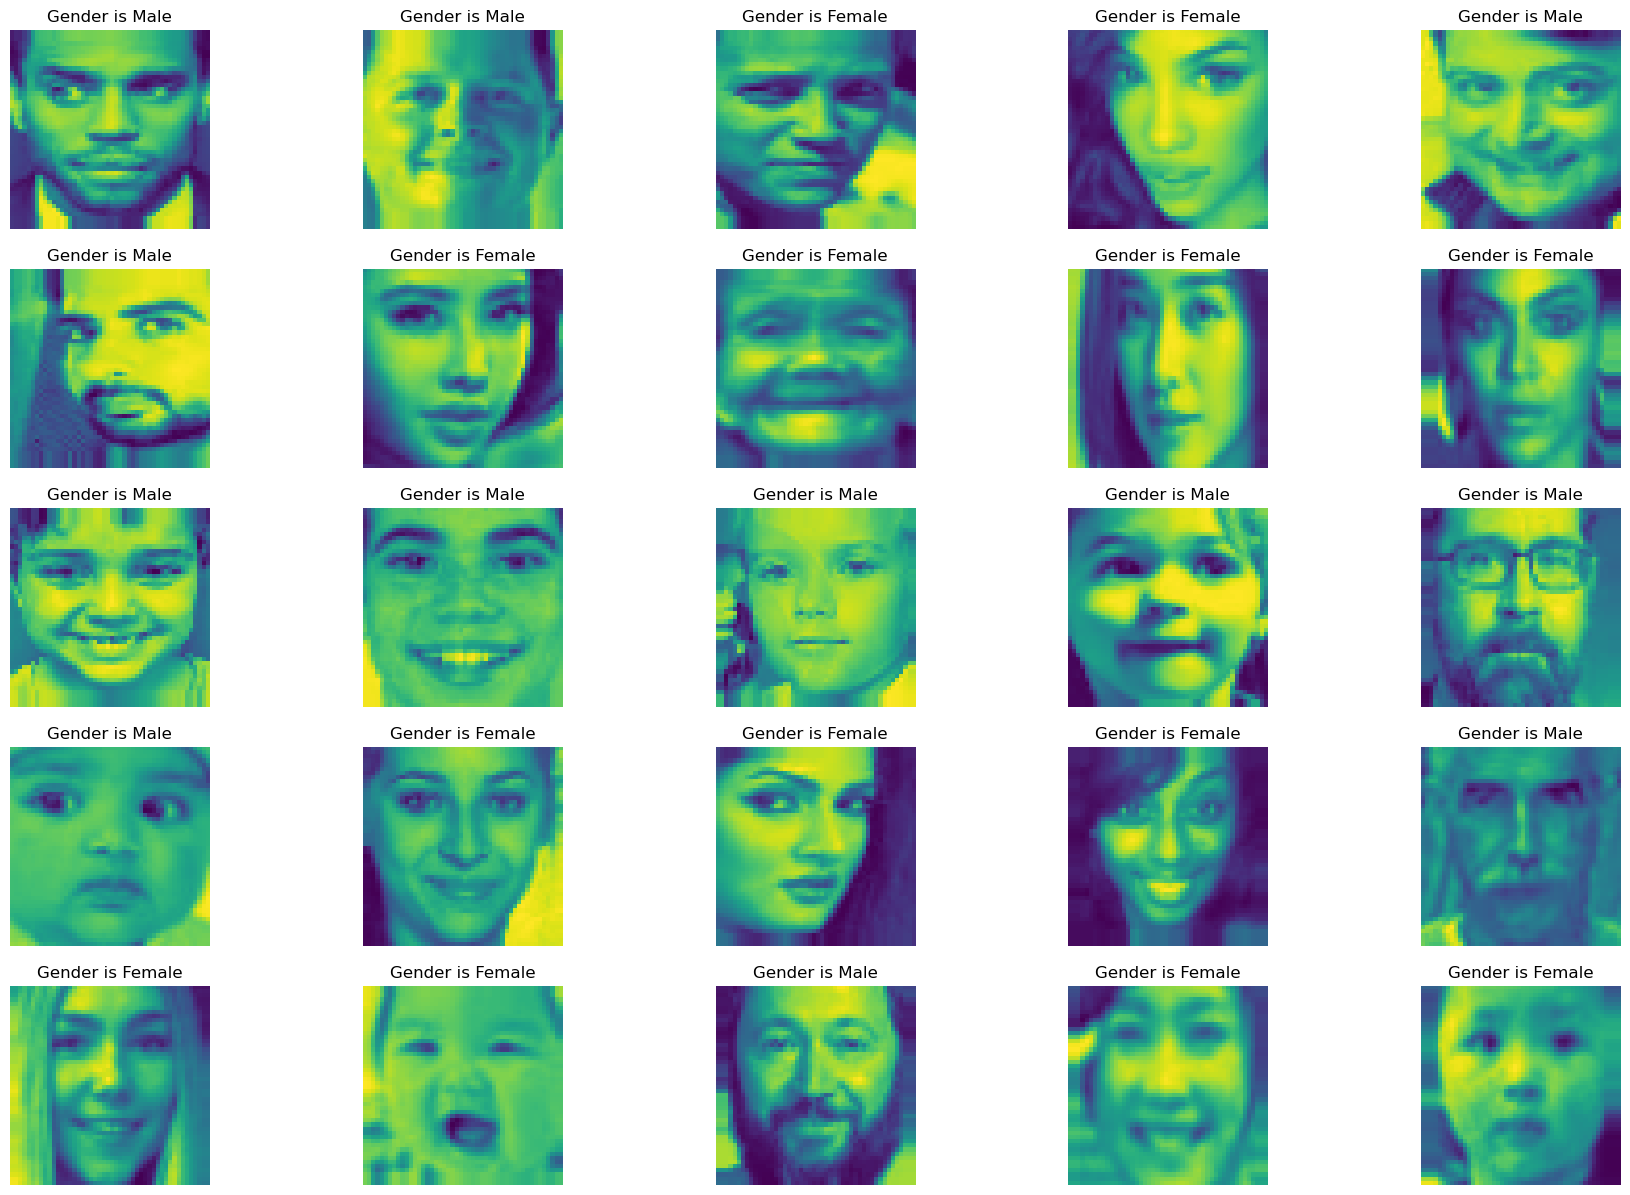

In [33]:
# one batch

def showImagesGender(img, label):
    plt.figure(figsize=(22,15))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title("Gender is {}".format(gender[label[i]]))
        plt.axis('off')
    plt.show()
    
A, b = next(gen_train_ds)
showImagesGender(A,b)

## Model

In [35]:
model_gender = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Dropout(0.3),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    #Conv2D(128, (3,3), activation='relu'),
    #MaxPooling2D(2,2),
    
    Flatten(),
    
    #Dense(256, activation='relu')
    #Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
    
])

model_gender.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          1

## compile the model

In [36]:
model_gender.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Callbacks

In [37]:
# Accuracy

my_calls_1 = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
              keras.callbacks.ModelCheckpoint("Model_Gender.h5", verbose=1, save_best_only=True)]

## Train

In [38]:
hist_gender = model_gender.fit(gen_train_ds, epochs=23, validation_data = gen_val_ds, callbacks = my_calls_1)

Epoch 1/23
502/504 [============================>.] - ETA: 0s - loss: 0.5746 - accuracy: 0.6939
Epoch 1: val_loss improved from inf to 0.42882, saving model to Model_Gender.h5
504/504 [==============================] - 15s 28ms/step - loss: 0.5738 - accuracy: 0.6945 - val_loss: 0.4288 - val_accuracy: 0.8021
Epoch 2/23
504/504 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.7965
Epoch 2: val_loss improved from 0.42882 to 0.37203, saving model to Model_Gender.h5
504/504 [==============================] - 14s 28ms/step - loss: 0.4419 - accuracy: 0.7965 - val_loss: 0.3720 - val_accuracy: 0.8228
Epoch 3/23
502/504 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8183
Epoch 3: val_loss improved from 0.37203 to 0.35385, saving model to Model_Gender.h5
504/504 [==============================] - 14s 27ms/step - loss: 0.4032 - accuracy: 0.8184 - val_loss: 0.3539 - val_accuracy: 0.8387
Epoch 4/23
502/504 [============================>.] - ETA: 0s - l

## Test

In [39]:
model_gender.evaluate(gen_test_ds)

149/149 [==============================] - 2s 12ms/step - loss: 0.2536 - accuracy: 0.8861


[0.2535906732082367, 0.8860999941825867]

## Loss and Accuracy

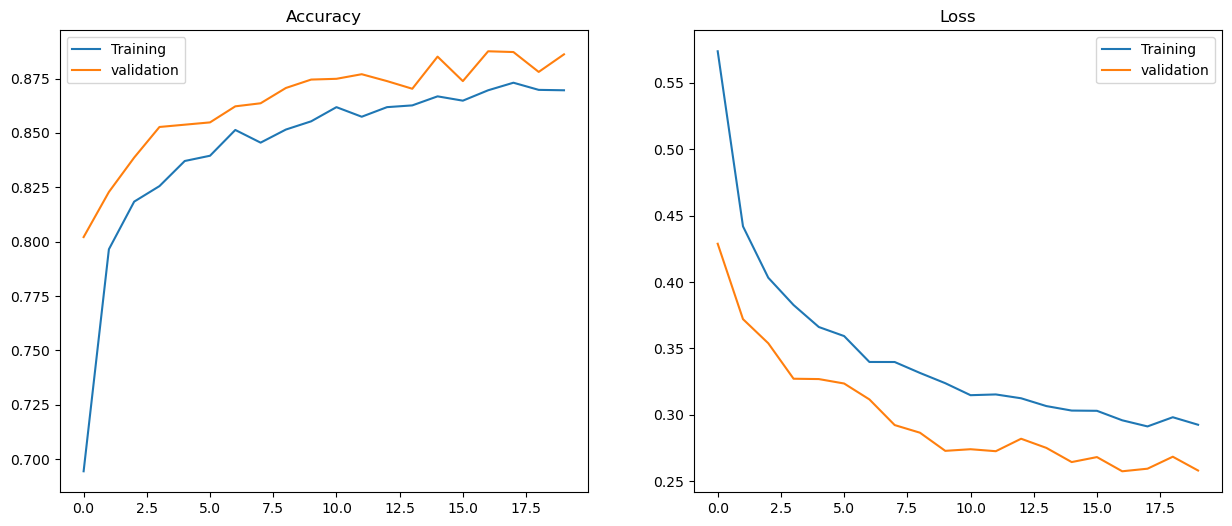

In [41]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(hist_gender.epoch, hist_gender.history['accuracy'], label='Training')
plt.plot(hist_gender.epoch, hist_gender.history['val_accuracy'], label='validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_gender.epoch, hist_gender.history['loss'], label='Training')
plt.plot(hist_gender.epoch, hist_gender.history['val_loss'], label='validation')

plt.title('Loss')
plt.legend()
plt.show()

Validation Accuracy is more than Trainning Accuracy.
Validation Loss is less than Training Loss too which is due to the higher accuracy score of validation process.

## Predictions

149/149 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2600
           1       0.85      0.90      0.88      2141

    accuracy                           0.89      4741
   macro avg       0.88      0.89      0.89      4741
weighted avg       0.89      0.89      0.89      4741



<Axes: >

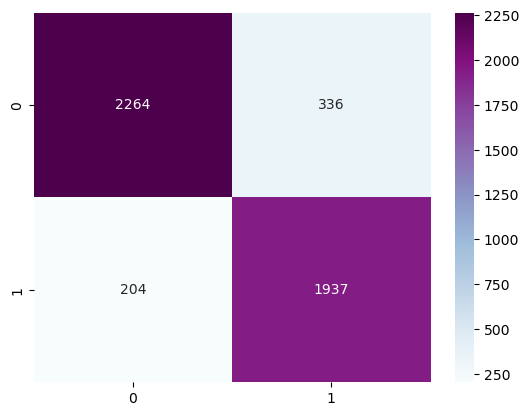

In [43]:
# Predicting the testing data
pred_gender = model_gender.predict(gen_test_ds)

pred_gen = []

for i in pred_gender: pred_gen.append(int(np.round(i[0])))
    
pred_gen[:5]

print(classification_report(pred_gen, Y_test_gender))

sns.heatmap(confusion_matrix(pred_gen, Y_test_gender), annot=True, fmt='d', cmap='BuPu')

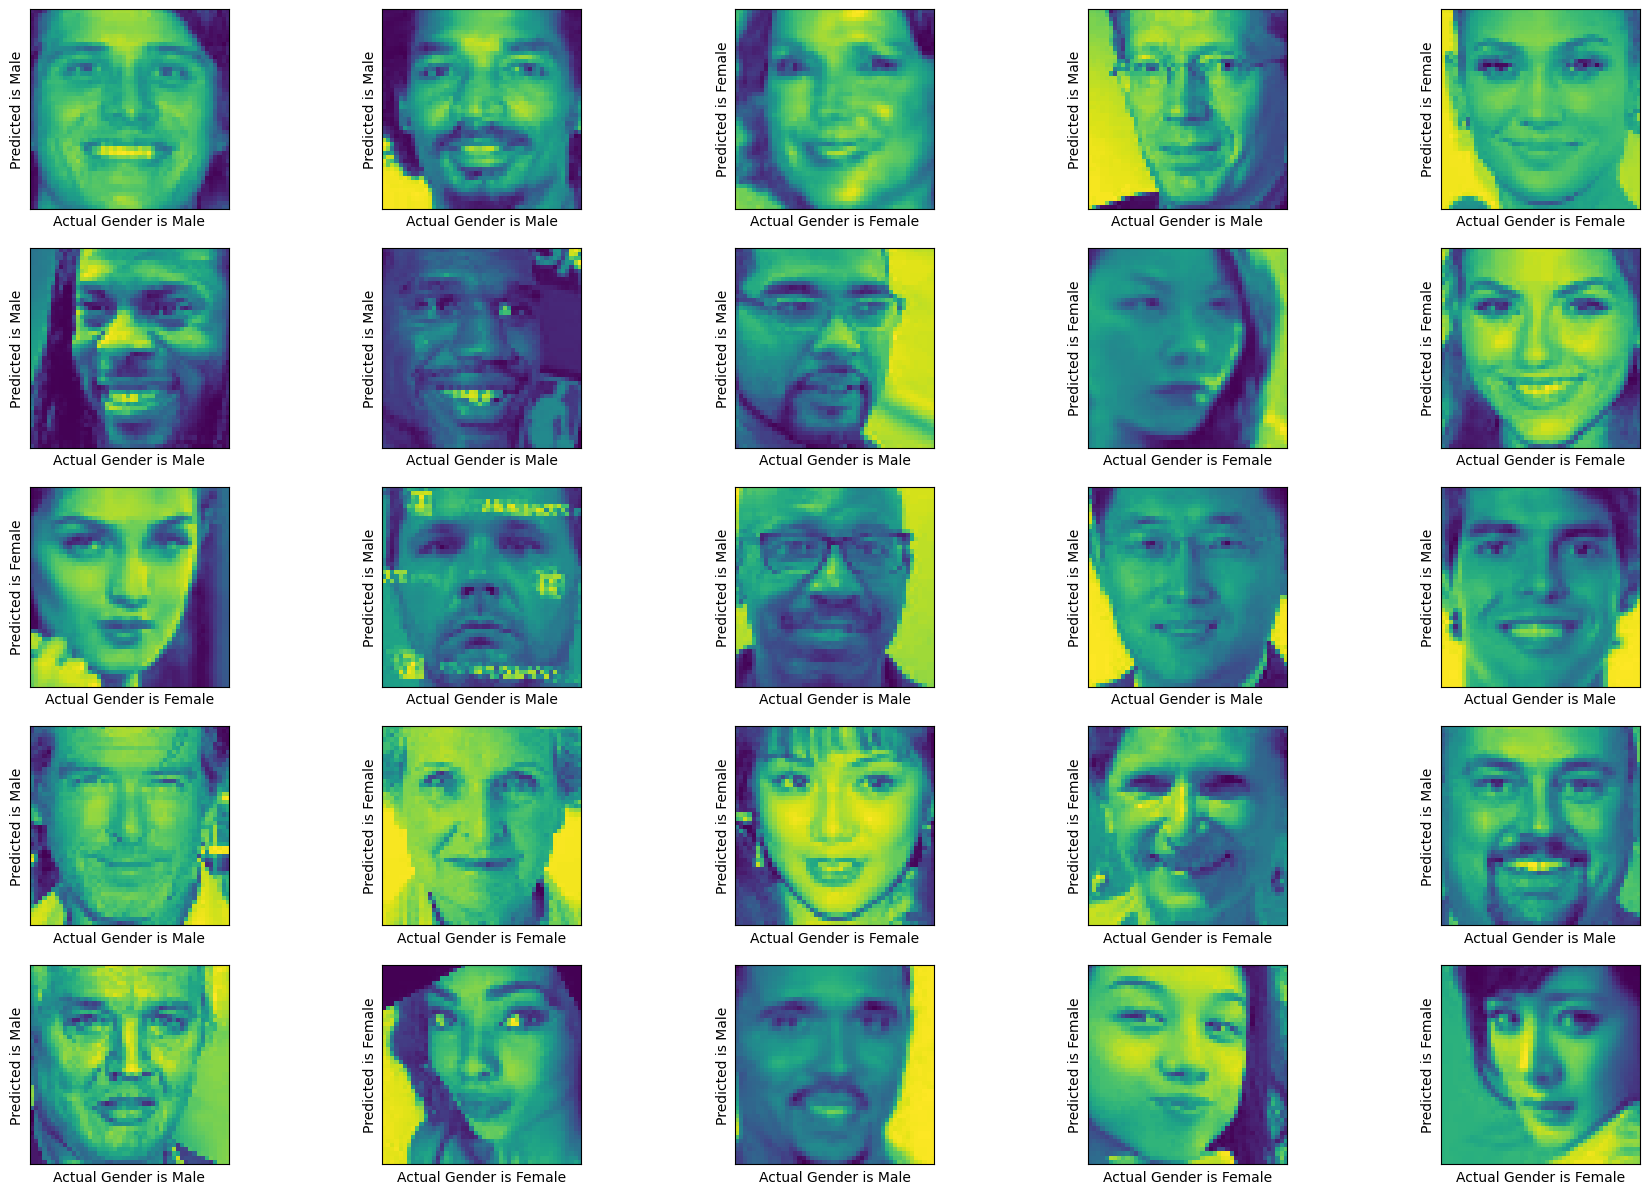

In [44]:
def testGender(image, pred, actual):
    plt.figure(figsize=(22,15))
    for i in range(500, 525):
        plt.subplot(5, 5, (i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[i])
        plt.xlabel("Actual Gender is {}".format(gender[actual[i]]))
        plt.ylabel("Predicted is {}".format(gender[pred[i]]))
    plt.show()
    
testGender(X_test_gender, pred_gen, Y_test_gender)

# Ethnicity Prediction

## Data for ethnicity prediction

In [45]:
# Split the data into training data and testing data
X_train_eth, X_test_eth, Y_train_eth, Y_test_eth = train_test_split(pixels, np.array(data['ethnicity']), random_state = 42, test_size = 0.2)

# Split the training set to be training data and validation data
X_train_eth, X_val_eth, Y_train_eth, Y_val_eth = train_test_split(X_train_eth, Y_train_eth, random_state = 21, test_size = 0.15)

In [46]:
(X_train_eth.shape, Y_train_eth.shape)

((16119, 48, 48, 1), (16119,))

In [47]:
# Train
eth_train_ds = traingen.flow(X_train_eth, Y_train_eth,
                             batch_size=32
                            )

# Validate
eth_val_ds = valgen.flow(X_val_eth, Y_val_eth,
                         batch_size=32
                        )

# Test
eth_test_ds = testgen.flow(X_test_eth, Y_test_eth,
                           batch_size=32,
                           shuffle=False
                          )

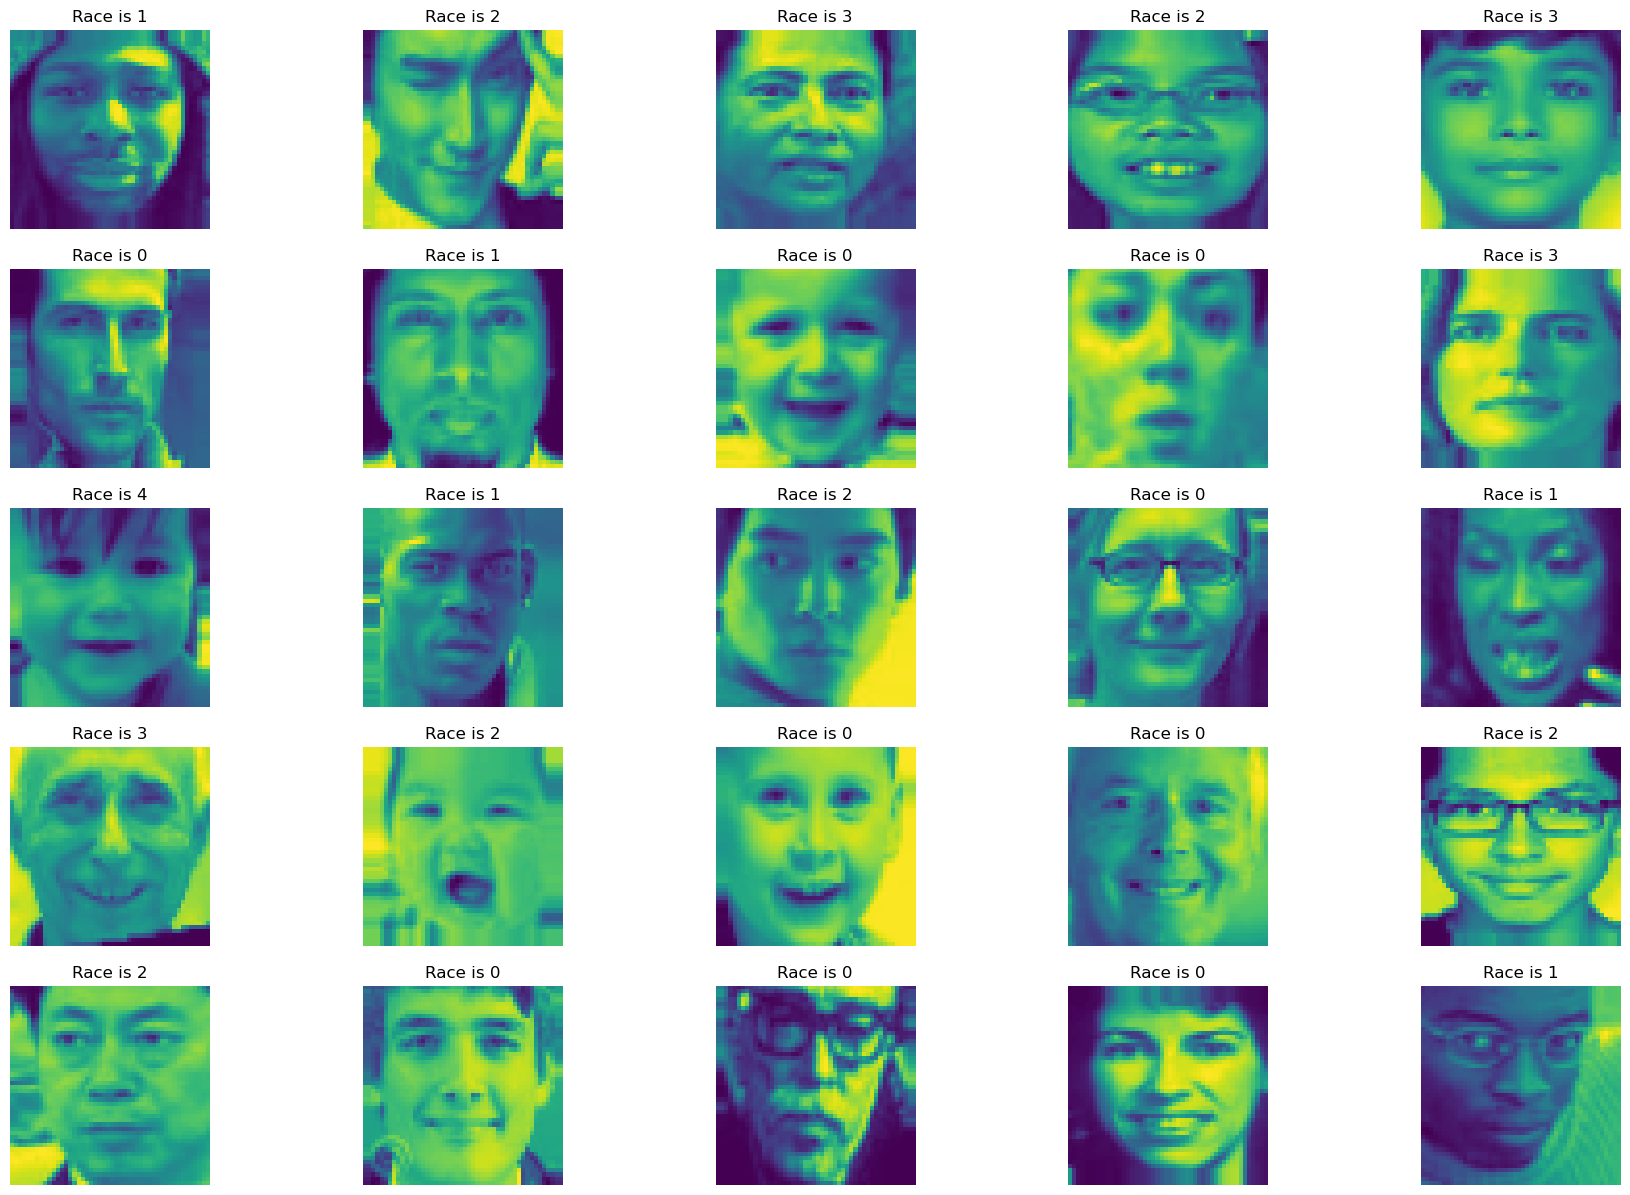

In [48]:
# One batch

def showImagesEthnicity(img, label):
    plt.figure(figsize=(22,15))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title("Race is {}".format(label[i]))
        plt.axis('off')
    plt.show()
    
c,d = next(eth_train_ds)
showImagesEthnicity(c,d)

## Model

In [58]:
model_eth = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Dropout(0.3),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    #Dense(64, activation='relu'),
    #Dropout(0.5),
    
    Dense(5, activation='softmax')
    
])

model_eth.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 10, 10, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 64)         

## Compile the model

In [51]:
# Loss = sparse_categorical_crossentropy, Metrics = accuracy

model_eth.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

## Callbacks

In [52]:
my_calls_2 = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
              keras.callbacks.ModelCheckpoint('Model_Ethnicity.h5', verbose=1, save_best_only=True)]

## Train

In [53]:
hist_eth = model_eth.fit(eth_train_ds, epochs=22, validation_data=eth_val_ds, 
                         callbacks=my_calls_2)

Epoch 1/22
504/504 [==============================] - ETA: 0s - loss: 1.4151 - accuracy: 0.4423
Epoch 1: val_loss improved from inf to 1.34178, saving model to Model_Ethnicity.h5
504/504 [==============================] - 14s 26ms/step - loss: 1.4151 - accuracy: 0.4423 - val_loss: 1.3418 - val_accuracy: 0.4826
Epoch 2/22
  3/504 [..............................] - ETA: 13s - loss: 1.2799 - accuracy: 0.5104

C:\Users\Alive\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


502/504 [============================>.] - ETA: 0s - loss: 1.2555 - accuracy: 0.5108
Epoch 2: val_loss improved from 1.34178 to 1.07308, saving model to Model_Ethnicity.h5
504/504 [==============================] - 13s 26ms/step - loss: 1.2549 - accuracy: 0.5111 - val_loss: 1.0731 - val_accuracy: 0.5986
Epoch 3/22
503/504 [============================>.] - ETA: 0s - loss: 1.0552 - accuracy: 0.6083
Epoch 3: val_loss improved from 1.07308 to 0.92595, saving model to Model_Ethnicity.h5
504/504 [==============================] - 14s 27ms/step - loss: 1.0557 - accuracy: 0.6082 - val_loss: 0.9259 - val_accuracy: 0.6770
Epoch 4/22
503/504 [============================>.] - ETA: 0s - loss: 0.9759 - accuracy: 0.6436
Epoch 4: val_loss improved from 0.92595 to 0.84495, saving model to Model_Ethnicity.h5
504/504 [==============================] - 14s 27ms/step - loss: 0.9756 - accuracy: 0.6437 - val_loss: 0.8450 - val_accuracy: 0.6960
Epoch 5/22
504/504 [==============================] - ETA: 0s -

## Test

In [54]:
model_eth.evaluate(eth_test_ds)

# Accuracy = 75%

149/149 [==============================] - 2s 10ms/step - loss: 0.7055 - accuracy: 0.7501


[0.7054610848426819, 0.7500527501106262]

## Loss and Accuracy

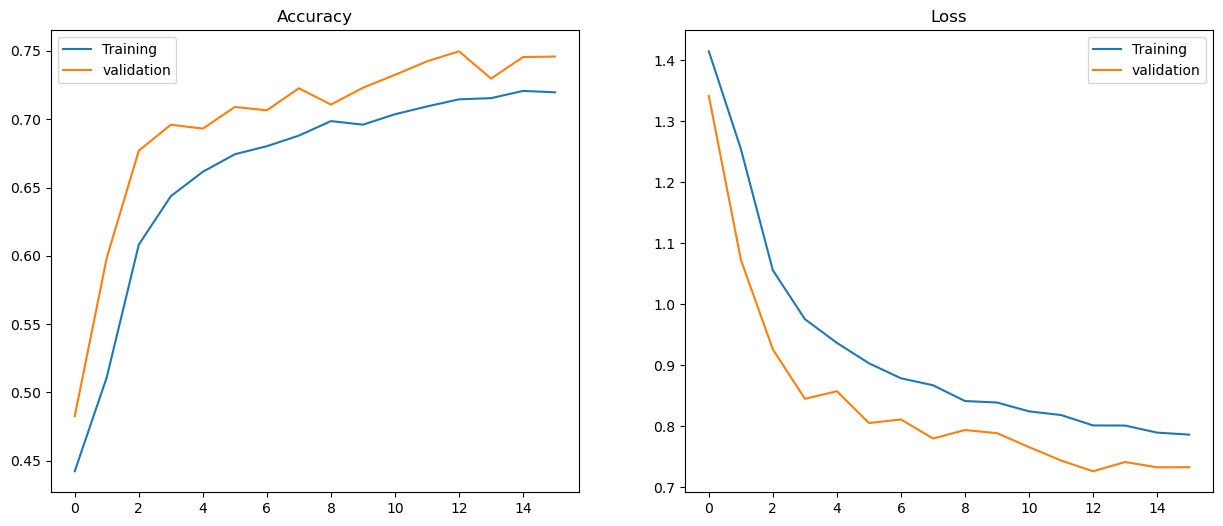

In [55]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(hist_eth.epoch, hist_eth.history['accuracy'], label='Training')
plt.plot(hist_eth.epoch, hist_eth.history['val_accuracy'], label='validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_eth.epoch, hist_eth.history['loss'], label='Training')
plt.plot(hist_eth.epoch, hist_eth.history['val_loss'], label='validation')

plt.title('Loss')
plt.legend()

plt.show()

Validation Accuracy is more than Training Accuracy.
Validation Loss is less than Training loss too.

## Predictions

149/149 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2201
           1       0.76      0.83      0.79       832
           2       0.78      0.75      0.76       680
           3       0.77      0.61      0.68      1015
           4       0.02      0.38      0.03        13

    accuracy                           0.75      4741
   macro avg       0.63      0.67      0.62      4741
weighted avg       0.80      0.75      0.77      4741



<Axes: >

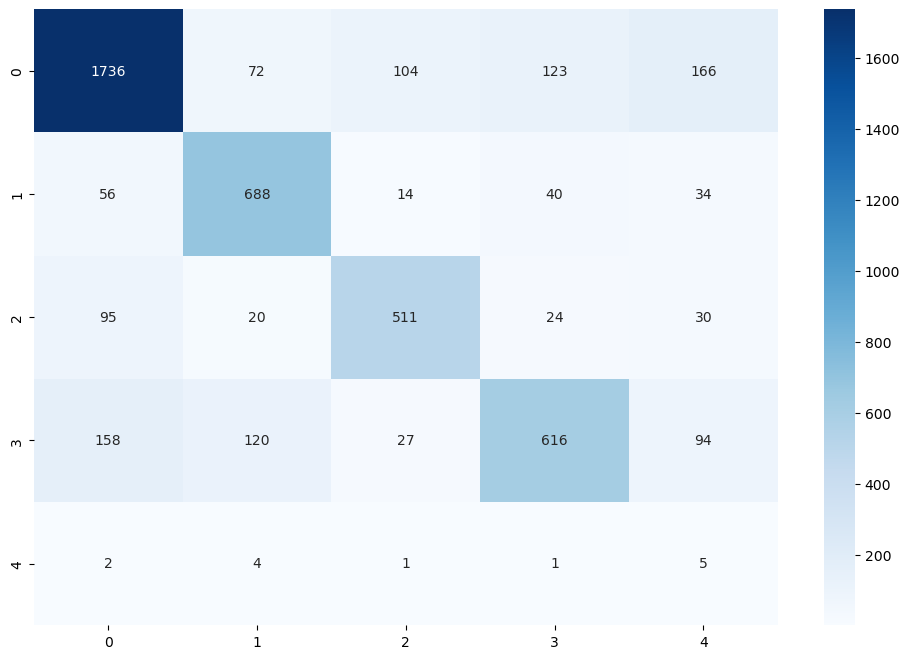

In [56]:
pred_eth = model_eth.predict(eth_test_ds)

pred_eth = [np.argmax(i) for i in pred_eth]
pred_eth[:5]

pd.DataFrame(pred_eth).value_counts()

pd.DataFrame(Y_test_eth).value_counts()

print(classification_report(pred_eth, Y_test_eth))

plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(pred_eth, Y_test_eth), annot=True, fmt='d', cmap='Blues')

## Conclusion

Predicting age, gender, and race using computer vision is a challenging yet rewarding project. By meticulously collecting data, carefully designing and training models, and considering ethical implications, we can create systems that not only perform well but also serve society responsibly. The future of computer vision holds immense possibilities, and projects like these pave the way for more intelligent and inclusive technologies.

Reference: https://medium.com/@Coursesteach/age-gender-and-race-prediction-21acd3193bf4